In [1]:
#!tar xvzf "./annotations.tar.gz"

In [2]:
#!tar xvzf "./images.tar.gz"
#!pip install torchmetrics

In [1]:
# Importing libraries
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms.v2  import Resize, Lambda, Compose, ToPILImage, ColorJitter, RandomHorizontalFlip, RandomRotation, ToImage, ToDtype
from torchvision.tv_tensors import BoundingBoxes
import torch.nn.functional as F
from torchmetrics.regression import MeanSquaredError

import pandas as pd
import numpy as np
from xml.dom import minidom
import cv2 as cv
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/administrator/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def showImages(data, rows, cols,classNames):
    figure = plt.figure(figsize=(5,5))
    images, labels_gt, bb = data
    color = (255,255,255)
    thickness = 3
    for i in range(0,rows*cols):
        img = images[i]
        img = np.array(ToPILImage()(img))
        label_pred=labels_gt[i].argmax(-1).item()
        label_gt=labels_gt[i].argmax(-1).item()
        bbox=bb[i]
        img = cv.rectangle(img, (int(bbox[0].item()),int(bbox[1].item())), (int(bbox[2].item()),int(bbox[3].item())), color, thickness)
        figure.add_subplot(rows, cols, i+1)
        fontdict = {'fontsize': 8,'fontweight' : 5, 'verticalalignment': 'top', 'horizontalalignment': 'center'}
        plt.title(str(classNames[label_pred])+'-'+str(label_pred==label_gt),fontdict)
        plt.axis("off")
        plt.imshow(img)
    plt.show()

In [3]:
def plotAccAndLoss(t,classifRates,BBErrors,totalLosses,classifLosses,regLosses):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('epoch')
    color = 'tab:blue'
    ax1.set_ylabel('Learning losses', color=color)  # we already handled the x-label with ax1
    ax1.plot(t, totalLosses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    color = 'tab:green'
    ax1.plot(t, classifLosses, color=color)
    color = 'tab:orange'
    ax1.plot(t, regLosses, color=color)
    fig.tight_layout() 
    plt.legend(["Total Loss", "Classif. Loss", "Reg. Loss"], loc="upper right")
    fig2, ax2 = plt.subplots()
    color = 'tab:red'
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('Recognition rate', color=color)
    ax2.plot(t, classifRates, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax3 = ax2.twinx()  
    color = 'tab:blue'
    ax3.set_ylabel('BoundingBox RMSE', color=color)  
    ax3.plot(t, BBErrors, color=color)
    ax3.tick_params(axis='y', labelcolor=color)
    fig2.tight_layout()  
    plt.show()

In [4]:
# Definition of the pytorch dataset for Oxford-IIIT Pets dataset
class DatasetOxfordIIIT(Dataset):
    def __init__(self, file_path, input_transform=None, target_transform=None):
        self.data = np.asarray(pd.read_csv(file_path,sep=' '))
        self.input_transform = input_transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        
        image_path="./images/"+self.data[index][0]+".jpg"
        image = cv.imread(image_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = image.astype(np.uint8)

        label = self.data[index][1]   
        
        label_path = "./annotations/xmls/"+self.data[index][0]+".xml"
        bndbox = []
        try:
          with open(label_path, 'r') as f:
            file = minidom.parse(label_path)
            xmin = float(file.getElementsByTagName('xmin')[0].firstChild.nodeValue)
            ymin = float(file.getElementsByTagName('ymin')[0].firstChild.nodeValue)
            xmax = float(file.getElementsByTagName('xmax')[0].firstChild.nodeValue)
            ymax = float(file.getElementsByTagName('ymax')[0].firstChild.nodeValue)
            box = BoundingBoxes([[xmin,ymin,xmax,ymax]],format="XYXY", canvas_size=(image.shape[0],image.shape[1]))
        except IOError:
            box = BoundingBoxes([[0.0,0.0,0.0,0.0]],format="XYXY", canvas_size=(image.shape[0],image.shape[1]))
            
        if self.input_transform is not None:
            image, box = self.input_transform(image,box)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return image, label, box[0]

    def getClassNames(self):
      classNames={}
      for index in range(0,len(self.data)):
        t = self.data[index][0].split('_')
        classNames[self.data[index][1]]=t[0]
      return classNames

In [5]:
# Transformations applied to training data
train_transform=Compose([ToImage(),ToDtype(torch.float32, scale=True),RandomRotation(30),RandomHorizontalFlip(0.5),ColorJitter(brightness=.5,contrast=.5),Resize((128,128))])
#train_transform=Compose([ToImage(),ToDtype(torch.float32, scale=True),Resize((128,128))])
# Transformations applied to validation data
val_transform=Compose([ToImage(), ToDtype(torch.float32, scale=True),Resize((128,128))])
# Transformation applied to labels
target_transform=Compose([lambda y:F.one_hot(torch.tensor(y),38).float()])

# Creation of the dataset DatasetOxfordIIIT
datasetOxTrain = DatasetOxfordIIIT("./annotations/trainval.txt",train_transform,target_transform)
datasetOxVal = DatasetOxfordIIIT("./annotations/trainval.txt",val_transform,target_transform)
# Create the index splits for training, validation and test
train_size = 0.9
num_train = len(datasetOxTrain)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[:split], indices[split:]
trainData = torch.utils.data.Subset(datasetOxTrain, indices=train_idx)
valData = torch.utils.data.Subset(datasetOxVal, indices=valid_idx)

dataloaderOxTrain = DataLoader(trainData, batch_size=4,shuffle=True,pin_memory = True)
dataloaderOxVal = DataLoader(valData, batch_size=4,shuffle=True,pin_memory = True)

datasetOxTest = DatasetOxfordIIIT("./annotations/test.txt",val_transform,target_transform)
dataloaderOxTest = DataLoader(datasetOxTest, batch_size=25,shuffle=True,pin_memory = True)

classNames = datasetOxTrain.getClassNames()

Data used for training the model


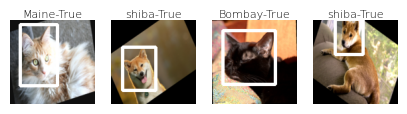

Data used for validating the model


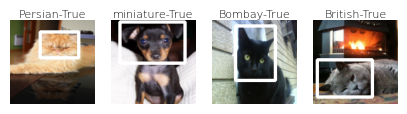

Data used for testing the model


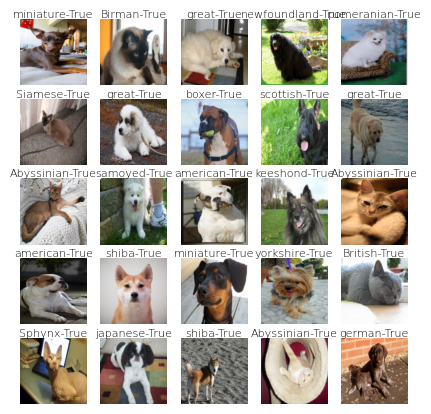

In [6]:
print("Data used for training the model")
dataTrain = next(iter(dataloaderOxTrain))
showImages(dataTrain, 1, 4,classNames)

print("Data used for validating the model")
dataVal = next(iter(dataloaderOxVal))
showImages(dataVal, 1, 4,classNames)

print("Data used for testing the model")
dataTest = next(iter(dataloaderOxTest))
showImages(dataTest, 5, 5,classNames)

In [7]:
from torch import nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights, vgg16, VGG16_Weights
import torchvision.ops

class monReseau(nn.Module):
    def __init__(self):
        super(monReseau, self).__init__()       # input  (1,128,128) 28 28
        self.conv1 = nn.Conv2d(3, 64, 5)         # output (64,124,124) 24 24
        self.conv1_bn = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2)            # output (64,62,62) 12 12
        self.conv2 = nn.Conv2d(64, 128, 5)        # output (128,58,58) 8 8
        self.conv2_bn = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2)            # output (128,29,29) 4 4
        self.conv3 = nn.Conv2d(128, 256, 5)        # output (256,25,25) 8 8
        self.conv3_bn = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2)            # output (256,12,12) 4 4

        self.linearClassif1 = nn.Linear(256*12*12, 2048)   # 1ère couche linéaire 64*29*29 -> 1024
        self.linearClassif2 = nn.Linear(2048, 38)       # 2ème couche linéaire 1024 -> 38

        self.linearBBReg1 = nn.Linear(256*12*12, 2048)   # 1ère couche linéaire 64*29*29 -> 1024
        self.linearBBReg2 = nn.Linear(2048, 4)       # 2ème couche linéaire 1024 -> 4

    def forward(self, input):
        output = self.pool1(F.relu(self.conv1_bn(self.conv1(input))))
        output = self.pool2(F.relu(self.conv2_bn(self.conv2(output))))
        output = self.pool3(F.relu(self.conv3_bn(self.conv3(output))))
        output_conv = torch.flatten(output,1)

        output_Classif = F.relu(self.linearClassif1(output_conv))
        output_Classif = F.log_softmax(self.linearClassif2(output_Classif),dim=1)

        output_reg = F.relu(self.linearBBReg1(output_conv))
        output_reg = F.relu(self.linearBBReg2(output_reg))

        return output_Classif, output_reg

In [8]:
class ResNet50DNC(nn.Module):
    def __init__(self):
        super(ResNet50DNC, self).__init__()       # input  (1,128,128) 28 28
        self.encoder = resnet50()#weights=ResNet50_Weights.DEFAULT)
        self.encoder.fc = nn.Linear(2048, 1024)   # 1ère couche linéaire 64*29*29 -> 1024
        self.linearClassif = nn.Linear(1024, 38)       # 2ème couche linéaire 1024 -> 38
        self.linearBBReg = nn.Linear(1024, 4)       # 2ème couche linéaire 1024 -> 4
        
    def forward(self, input):
        output_enc = self.encoder(input)
        output_Classif = F.log_softmax(self.linearClassif(output_enc),dim=1)
        output_reg = F.relu(self.linearBBReg(output_enc))
        return output_Classif, output_reg

In [9]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()       # input  (1,128,128) 28 28
        self.encoder = vgg16(weights=VGG16_Weights.DEFAULT)
        self.encoder.classifier = nn.Linear(25088, 2048)   # 1ère couche linéaire 64*29*29 -> 1024
        self.linearClassif = nn.Linear(2048, 38)       # 2ème couche linéaire 1024 -> 38
        self.linearBBReg = nn.Linear(2048, 4)       # 2ème couche linéaire 1024 -> 4
        

    def forward(self, input):
        output_enc = self.encoder(input)
        output_Classif = F.log_softmax(self.linearClassif(output_enc),dim=1)
        output_reg = F.relu(self.linearBBReg(output_enc))
        return output_Classif, output_reg

In [10]:
def train(dataloader, model,classifLoss, regLoss, optim, device, classNames):
    size = len(dataloader.dataset)
    model.train(True)
    meanLoss = 0
    meanCLoss = 0
    meanRLoss = 0
    total = 0
    for step, data in enumerate(dataloader):
        inputs, labels, bndbox = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        bndbox = bndbox.to(device)
        pred_classif, pred_BB = model(inputs)
        CLoss = classifLoss(pred_classif, labels)
        meanCLoss += CLoss.item()
        RLoss = torch.sqrt(regLoss(pred_BB,bndbox))/8
        meanRLoss += RLoss.item()
        loss = CLoss + RLoss
        optim.zero_grad()
        loss.backward()
        optim.step()
        meanLoss = meanLoss + loss.item()
        total += labels.size(0)
        if step % 200 == 0:
            print("Batch number : " + str(step)+" loss : "+str(meanLoss/total))
    print("total",total)
    return meanLoss/total, meanCLoss/total, meanRLoss/total

In [11]:
def val(dataloader, model, device, regMetric):
    correct = 0
    total = 0
    meanBB_Error = 0.0
    model.eval()
    with torch.no_grad(): 
        for data in dataloader:
             inputs, labels, bndbox = data
             inputs = inputs.to(device)
             labels = labels.to(device)
             bndbox = bndbox.to(device)
             pred_classif, pred_BB = model(inputs)
             predicted = pred_classif.argmax(1)
             labels = labels.argmax(1)
             total += labels.size(0)
             correct += (predicted == labels).sum().item()
             BB_error = torch.sqrt(regMetric(pred_BB,bndbox))
             meanBB_Error += BB_error.item()
    return 100*correct/total, meanBB_Error/total

In [12]:
def test(dataloader, model, device, classNames):
    figure = plt.figure(figsize=(5,5))
    cols, rows = 5,5
    with torch.no_grad(): 
            inputs, labels_gt, bb = next(iter(dataloader))
            inputs = inputs.to(device)
            labels_pred, bndboxes = model(inputs)
            color = (255,255,255)
            thickness = 3
            for i in range(0,labels_gt.size(dim=0)):
              image_clone = np.array(ToPILImage()(inputs[i]))
              label_pred=labels_pred[i].argmax(-1).item()
              label_gt=labels_gt[i].argmax(-1).item()
              bndbox=bndboxes[i]
              image_clone = cv.rectangle(image_clone, (int(bndbox[0].item()),int(bndbox[1].item())), (int(bndbox[2].item()),int(bndbox[3].item())), color, thickness)
              figure.add_subplot(rows, cols, i+1)
              fontdict = {'fontsize': 8,'fontweight' : 5, 'verticalalignment': 'top', 'horizontalalignment': 'center'}
              plt.title(str(classNames[label_pred])+'-'+str(label_pred==label_gt),fontdict)
              plt.axis("off")
              plt.imshow(image_clone)
            plt.show()

cuda
ResNet50DNC(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch number : 200 loss : 2.973309550119277


Corrupt JPEG data: premature end of data segment


Batch number : 400 loss : 2.8578648156953275
Batch number : 600 loss : 2.632596149024075
Batch number : 800 loss : 2.406237696440479
total 3311


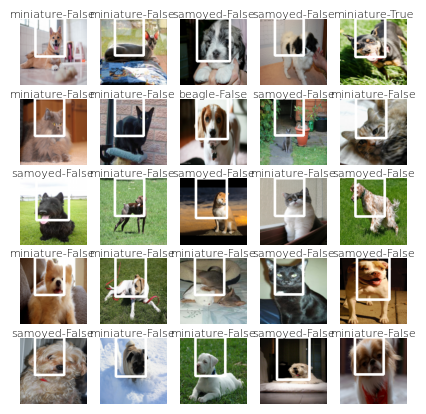

Précision : 1.9021739130434783 %


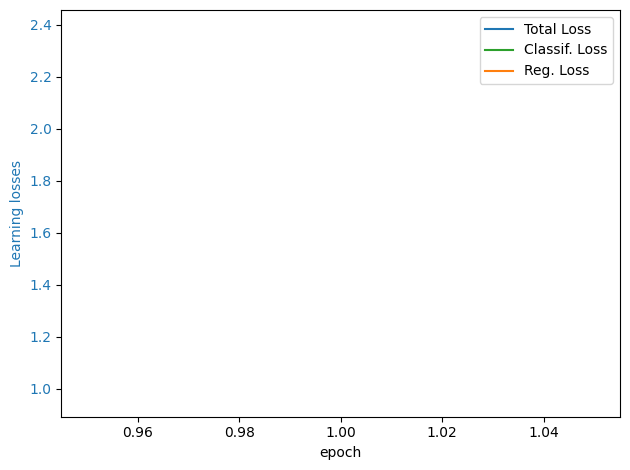

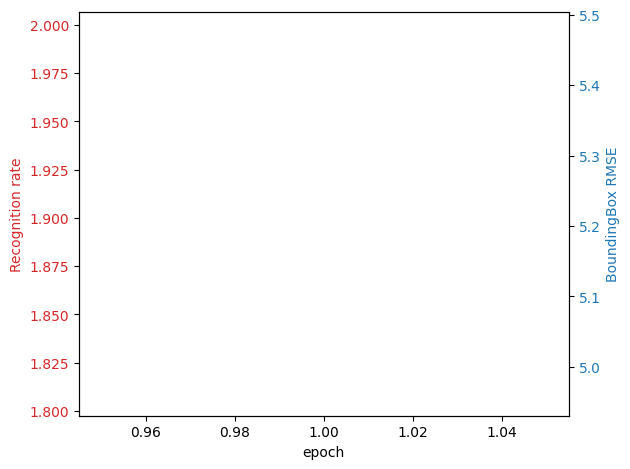

Nombre d epochs : 2
Batch number : 0 loss : 1.6589138507843018
Batch number : 200 loss : 1.6864552343662698


Corrupt JPEG data: premature end of data segment


Batch number : 400 loss : 1.6793474538665163


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch number : 600 loss : 1.6688926523418077
Batch number : 800 loss : 1.6626403404681125
total 3311


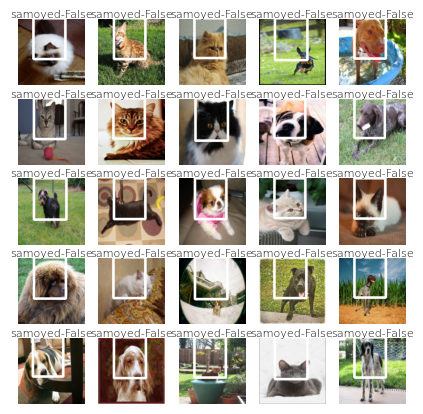

Précision : 2.1739130434782608 %


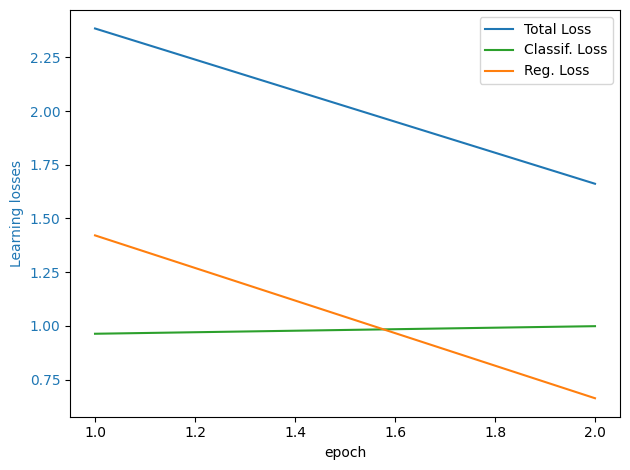

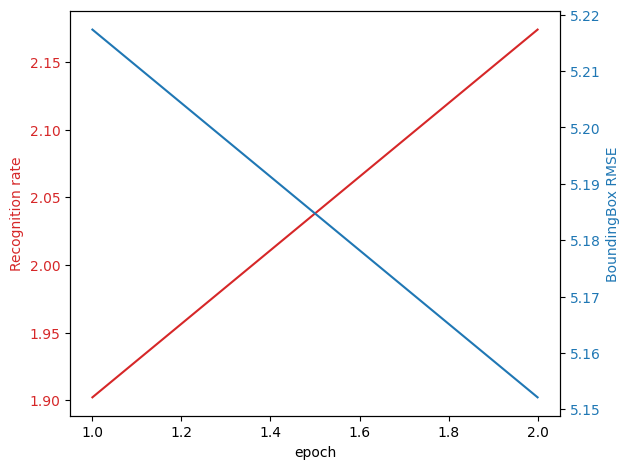

Nombre d epochs : 3
Batch number : 0 loss : 1.6302151679992676
Batch number : 200 loss : 1.6421980069051334


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch number : 400 loss : 1.6464707783035506
Batch number : 600 loss : 1.6429165722724801
Batch number : 800 loss : 1.6449173991004478
total 3311


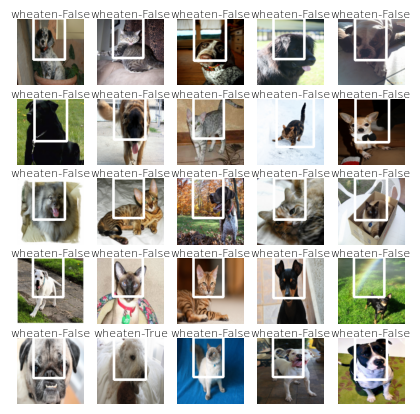

Précision : 1.6304347826086956 %


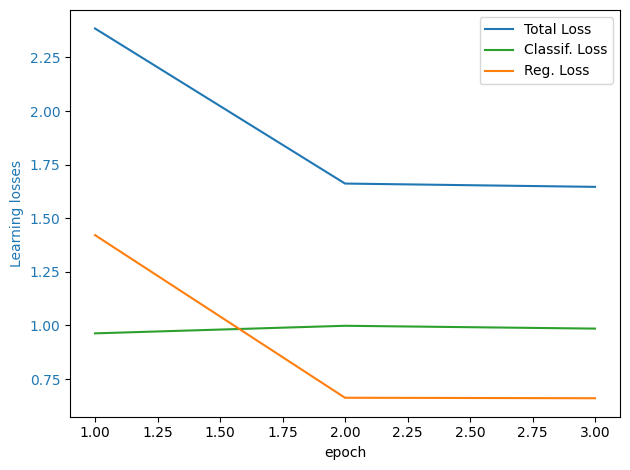

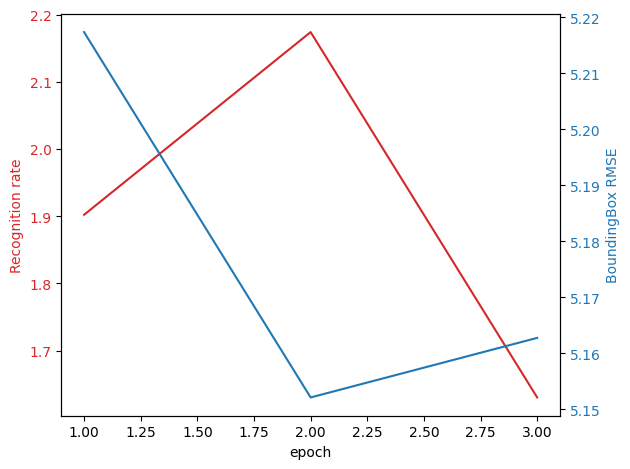

Nombre d epochs : 4
Batch number : 0 loss : 1.5808348655700684


Corrupt JPEG data: premature end of data segment


Batch number : 200 loss : 1.639206580854767
Batch number : 400 loss : 1.6409778850631525


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch number : 600 loss : 1.6343788146575953
Batch number : 800 loss : 1.6336150316709883
total 3311


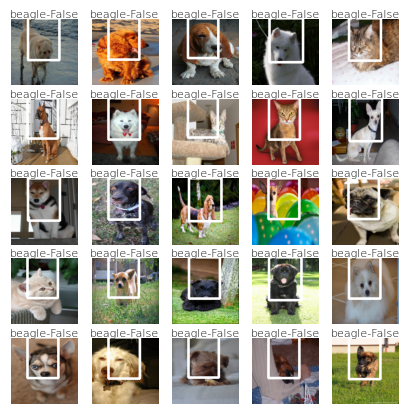

Précision : 1.9021739130434783 %


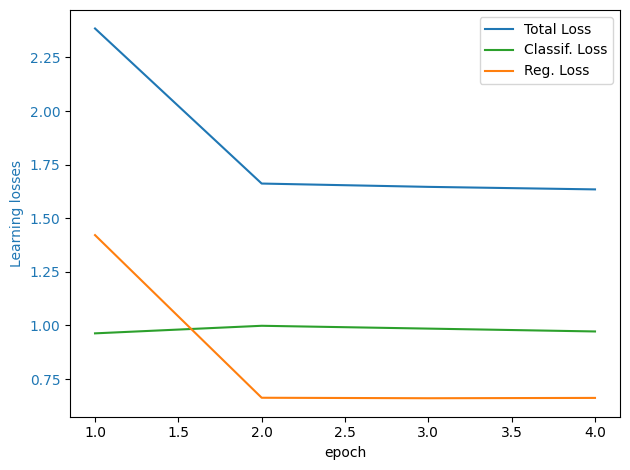

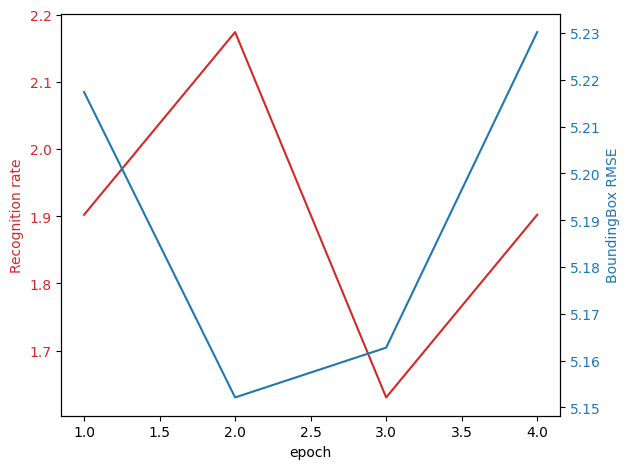

Nombre d epochs : 5
Batch number : 0 loss : 1.6651108264923096
Batch number : 200 loss : 1.6290819994845793


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch number : 400 loss : 1.6251205304019767


Corrupt JPEG data: premature end of data segment


Batch number : 600 loss : 1.6242109874322292
Batch number : 800 loss : 1.6226112655039584
total 3311


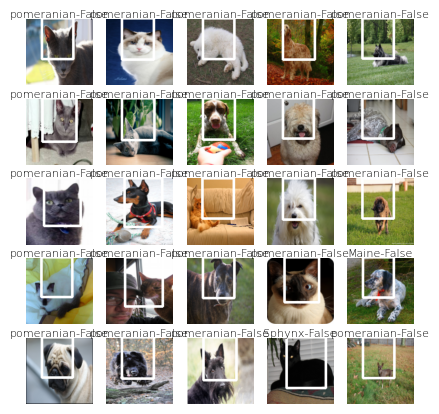

Précision : 2.4456521739130435 %


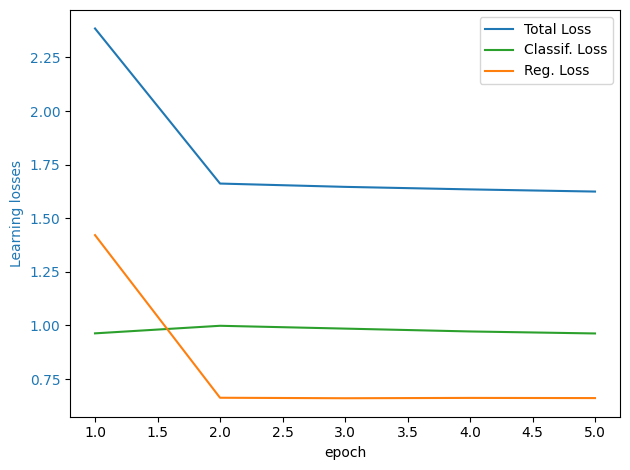

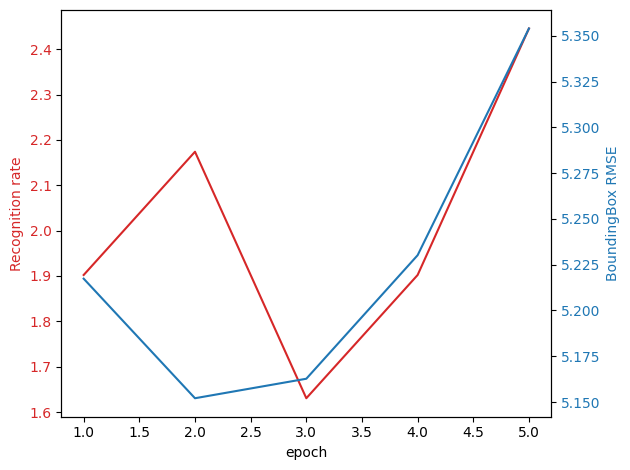

Nombre d epochs : 6
Batch number : 0 loss : 1.6162060499191284


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch number : 200 loss : 1.6364417248104342


Corrupt JPEG data: premature end of data segment


Batch number : 400 loss : 1.6310653689496237
Batch number : 600 loss : 1.6221552498130354
Batch number : 800 loss : 1.621155099773526
total 3311


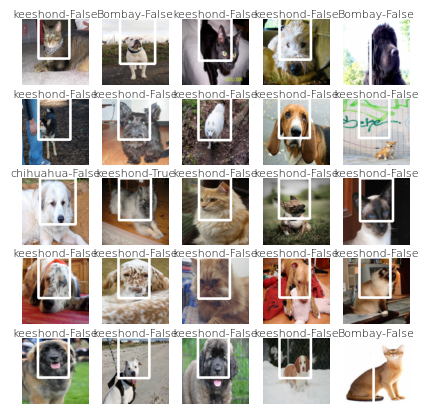

Précision : 4.076086956521739 %


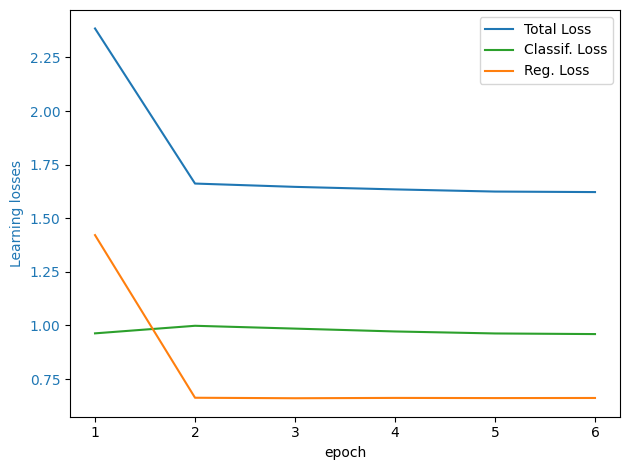

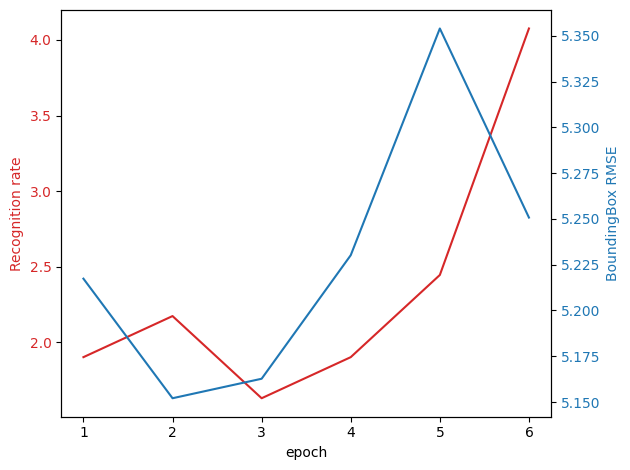

Nombre d epochs : 7
Batch number : 0 loss : 1.8068681955337524


Corrupt JPEG data: premature end of data segment


Batch number : 200 loss : 1.6236557877478908


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch number : 400 loss : 1.62104582013632
Batch number : 600 loss : 1.6190465226546302


In [ ]:
if torch.cuda.is_available():
      device = 'cuda'
else:
      device = 'cpu'
print(device)

#monModel = monReseau().to(device)
monModel = ResNet50DNC().to(device)
#monModel = VGG16().to(device)

print(monModel)

ClassifLoss = nn.CrossEntropyLoss()
RegLoss = nn.MSELoss()
MSE = MeanSquaredError().to(device)
tx_appr = 0.001
optim = torch.optim.SGD(monModel.parameters(), lr=tx_appr, momentum=0.1)
epochs = 200
t= []

totalLosses= []
classifLosses = []
regLosses = []

classifRates =[]
BBErrors = []

classNames = datasetOxTrain.getClassNames()
print(classNames)
for i in range(epochs):
    t.append(i+1)
    print('Nombre d epochs : '+str(i+1))
    totalLoss, classifLoss, regLoss = train(dataloaderOxTrain, monModel, ClassifLoss, RegLoss, optim, device, classNames)
    totalLosses.append(totalLoss)
    classifLosses.append(classifLoss)
    regLosses.append(regLoss)
    
    classifRate, BBError = val(dataloaderOxVal, monModel, device, MSE)
    classifRates.append(classifRate)
    BBErrors.append(BBError)
    
    test(dataloaderOxTest, monModel, device, classNames)
    
    print('Précision : '+str(classifRate)+' %')
    plotAccAndLoss(t,classifRates,BBErrors,totalLosses,classifLosses,regLosses)